In [1]:
!git clone https://github.com/mohahf19/public-annrl-files.git 
!cp -r public-annrl-files/* .
!rm -r public-annrl-files

Cloning into 'public-annrl-files'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17 (delta 0), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), 22.56 KiB | 2.82 MiB/s, done.


In [17]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
from typing import Callable

from pathlib import Path

import torch
from torch import nn, optim

from tqdm import tqdm
import random
from collections import namedtuple, deque
import json


%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


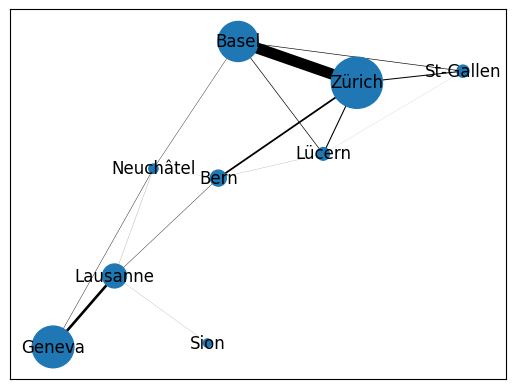

In [3]:
dyn = ModelDynamics("config/switzerland.yaml")  # load the switzerland map
print(dyn.cities)
dyn.draw_map()

In [4]:
action = {  # DO NOTHING
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

# Actually, actions can be any combination of the four.
action_value_dict = {0: "confinement", 1: "isolation", 2: "hospital", 3: "vaccinate"}

num_actions = 2**1  # If only for confinement
num_cities = len(dyn.cities)
num_features_per_city = 2  # infected, dead
num_observation_features = num_cities * (num_features_per_city * 7)


def observation_to_tensor(
    obs: Observation,
    dyn: ModelDynamics,
    features_per_city: int = 7 * num_features_per_city,
) -> torch.Tensor:
    """Convers the observation object to a torch Tensor
    The tensor is defined as: for each city, population (1), infected (7), dead (7)
    """
    num_cities = len(dyn.cities)
    output = torch.zeros(num_cities * features_per_city)
    for i, city in enumerate(dyn.cities):
        # output[i * features_per_city] = obs.pop[city]
        # output[i * features_per_city + 1 : i * features_per_city + 8] =  torch.tensor(obs.city[city].infected)
        # output[i * features_per_city + 8 : i * features_per_city + 15] =  torch.tensor(obs.city[city].dead)
        output[i * features_per_city : i * features_per_city + 7] = (
            torch.tensor(obs.city[city].infected) / obs.pop[city]
        ) ** (1 / 4)
        output[i * features_per_city + 7 : i * features_per_city + 14] = (
            torch.tensor(obs.city[city].dead) / obs.pop[city]
        ) ** (1 / 4)
        
    return output


"""Loading the environment"""
env = Env(
    dyn,  # We pass the dynamical model to the environment
    action_space=spaces.Discrete(
        num_actions
    ),  # Here one could pass an openai gym action space that can then be sampled
    observation_space=spaces.Box(
        low=0, high=np.inf, shape=(num_observation_features,), dtype=float
    ),  # Here one could pass an openai gym obs space that can then be sampled
)


def action_value_to_actions(action_value: int) -> list[int]:
    bin_str = [int(char) for char in reversed(bin(action_value)[2:])]
    actions = []
    for i, val in enumerate(bin_str):
        if val == 1:
            actions.append(i)
    return actions


def create_action(
    action: int,
    action_value_to_actions: Callable = action_value_to_actions,
    action_value_dict: dict = action_value_dict,
) -> dict[str, bool]:
    """Creates a policy from the encoded action value"""
    actions = action_value_to_actions(action)
    policy = {x: False for x in action_value_dict.values()}
    policy.update({action_value_dict[x]: True for x in actions})
    return policy


print(
    env.observation_space.sample().shape,
    (a := env.action_space.sample()),
    action_value_to_actions(a),
    [action_value_dict[x] for x in action_value_to_actions(a)],
    create_action(0),  # no action
    create_action(1),  # confinement
    create_action(1 + 2),  # confine + isolate
)


(126,) 1 [0] ['confinement'] {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False} {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False} {'confinement': True, 'isolation': True, 'hospital': False, 'vaccinate': False}


In [5]:
num_cities * (num_features_per_city * 7)

126

In [6]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, bs: int):
        n_to_sample = bs if bs < len(self.memory) else len(self.memory)
        return random.sample(self.memory, n_to_sample)

    def __len__(self) -> int:
        return len(self.memory)

class DQNModel(nn.Module):
    def __init__(self, obs_dim: int, actions_dim: int, activation: str = "relu"):
        super().__init__()
        if activation == "relu":
            self.activation = nn.ReLU
        elif activation == "tanh":
            self.activation = nn.Tanh
        else:
            raise ValueError("Activation must be either relu or tanh")

        self.net = nn.Sequential(
            # nn.LayerNorm(obs_dim),
            nn.Linear(obs_dim, 64),
            self.activation(),
            nn.Linear(64, 32),
            self.activation(),
            nn.Linear(32, 16),
            self.activation(),
            nn.Linear(16, actions_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


dqn = DQNModel(env.observation_space.shape[0], 2**1, activation="relu")
obs = torch.randn(10, env.observation_space.shape[0])
output = dqn(obs)
print(output)
best_actions = output.argmax(axis=1)
action_lists = [action_value_to_actions(x) for x in best_actions]
print(action_lists)
action_values = [
    [action_value_dict[x] for x in action_list] for action_list in action_lists
]
print(action_values)


tensor([[-0.0920, -0.3389],
        [-0.1112, -0.3434],
        [-0.0881, -0.3411],
        [-0.1210, -0.3653],
        [-0.1549, -0.3818],
        [-0.0888, -0.3457],
        [-0.1084, -0.3558],
        [-0.0681, -0.3022],
        [-0.2017, -0.4050],
        [-0.1051, -0.3542]], grad_fn=<AddmmBackward0>)
[[], [], [], [], [], [], [], [], [], []]
[[], [], [], [], [], [], [], [], [], []]


In [7]:
def select_action(output: torch.Tensor, epsilon: float) -> int:
    """Selects an action based on the output of the DQN."""
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(output))
    else:
        return output.to("cpu").argmax().item()

In [8]:
def simulate_policy(
    policy_net: nn.Module,
    eval_seed_sequences: np.ndarray,
    discount_factor: float,
    device: str,
    logging: bool = False,
) -> list[float]:
    rewards = []
    policy_net.eval()
    for eval_seed in eval_seed_sequences:
        cumulative_reward = 0
        curr_discount_factor = 1
        done = False
        obs, info = env.reset(seed=eval_seed)
        obs_tensor = observation_to_tensor(obs, dyn).to(device)
        policy_net.to(device)

        while not done:
            policy_output = policy_net(obs_tensor)
            action = select_action(policy_output, epsilon=0)
            curr_action = create_action(action)
            obs, reward, done, info = env.step(curr_action)
            obs_tensor = observation_to_tensor(obs, dyn).to(device)
            if logging:
                # print(f"{action} ({reward.item():.2f})", end=" ")
                print(action, end= " ")
            reward = reward.to(device)

            cumulative_reward += curr_discount_factor * reward
            curr_discount_factor *= discount_factor
        rewards.append(cumulative_reward.item())
        if logging:
            print(f" -> reward: {cumulative_reward.item():.3f}")
            print(info.total)
            print()
    policy_net.train()
        
    return rewards

In [9]:
# optimize_model(policy_net, memory, optimizer, batch_size, discount_factor)
def optimize_model(
    policy_net: nn.Module,
    target_net: nn.Module,
    memory: ReplayMemory,
    optimizer: torch.optim,
    batch_size: int,
    discount_factor: float,
    scheduler: optim.lr_scheduler = None, 
    device: str = "cpu",
) -> None:
    """Optimizes the policy network based on a batch of transitions sampled from the replay memory. Only optmise if the replay memory is larger than the batch size."""
    # assert batch_size <= len(memory), "Insufficient memory to sample a batch."

    def criterion(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.nn.MSELoss()(x, y) / (2*len(x))
        # return torch.nn.SmoothL1Loss()(x, y) / (len(x))

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    state_b = torch.stack(batch.state).to(device)
    next_state_b = torch.stack(batch.next_state).to(device)
    action_b = torch.tensor(batch.action).to(device)
    reward_b = torch.tensor(batch.reward).to(device)

    policy_net.to(device)
    target_net.to(device)

    state_action_values = policy_net(state_b).gather(
        1, action_b.unsqueeze(1)
    )  # Computes Q_theta(s_t, a_t)
    next_state_values = target_net(next_state_b).max(1)[
        0
    ]  # Computes \hat{Q}(s_t+1) = max_a \hat{Q}(s_t+1, a)

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * discount_factor) + reward_b

    loss = criterion(
        expected_state_action_values, state_action_values.squeeze()
    )  # Difference between the expected Q values and the actual Q values
    # loss = expected_state_action_values - state_action_values.squeeze() # Difference between the expected Q values and the actual Q values

    # Optimize the model now
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()

    return loss.item()


def compute_epsilon(
    e_initial: float, e_min: float, total_steps: int, current_steps: int
) -> float:
    return max(e_min, e_initial * (total_steps - current_steps) / total_steps)

In [28]:
def run_train_experiment(load_cache, num_episodes, seed, learning_rate, discount_factor, 
                         target_update_per, evaluate_per, eval_seed_sequences, batch_size, 
                         buffer_size, epsilon_min, epsilon_init, device, run_id):
    torch.manual_seed(seed)
    np.random.seed(seed)
    num_eval_episodes = len(eval_seed_sequences)
    env_seed_sequences = np.random.randint(0, 1000, size=num_episodes)

    assert len(env_seed_sequences) == num_episodes


    ## Initializations
    obs, info = env.reset(seed=seed)
    n_actions = env.action_space.n
    n_observations = observation_to_tensor(obs, dyn).shape[0]


    model_save_path = Path("models")
    model_save_path.mkdir(exist_ok=True)
    best_model_path = model_save_path / f"dqn_q3a_{run_id}_best.pt"


    ## Policy and target networks
    if load_cache:
        print("Loading from cache")
        policy_net = DQNModel(n_observations, n_actions).to(device)
        policy_net.load_state_dict(torch.load(best_model_path))
        target_net = DQNModel(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
    else:
        print("Creating new models..")
        policy_net = DQNModel(n_observations, n_actions).to(device)
        target_net = DQNModel(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        
    memory = ReplayMemory(buffer_size)
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    tr_losses = []

    tr_trace, eval_trace_mean, eval_trace_std = [], [], []
    has_logged_started_training_message = False

    best_eval_reward = -np.inf


    for num_episode in range(num_episodes):
        obs, info = env.reset(seed=env_seed_sequences[num_episode])
        obs_tensor = observation_to_tensor(obs, dyn).to(device)

        done = False

        cumulative_tr_reward = 0
        curr_discount_factor = 1
        ep_losses = []
        while not done:  # play the episode
            policy_output = policy_net(obs_tensor)
            action = select_action(
                policy_output,
                epsilon=compute_epsilon(
                    epsilon_init, epsilon_min, num_episodes, num_episode
                ),
            )

            curr_action = create_action(action)

            obs, reward, done, info = env.step(curr_action)
            new_obs_tensor = observation_to_tensor(obs, dyn).to(device)
            reward = reward.to(device)

            memory.push(obs_tensor, action, new_obs_tensor, reward)
            obs_tensor = new_obs_tensor

            cumulative_tr_reward += curr_discount_factor * reward
            curr_discount_factor *= discount_factor

            if batch_size <= len(memory):
                if not has_logged_started_training_message:
                    print("Started training")
                    has_logged_started_training_message = True

                loss_val = optimize_model(
                    policy_net,
                    target_net,
                    memory,
                    optimizer,
                    batch_size,
                    discount_factor,
                    device=device,
                    scheduler=scheduler,
                )
                tr_losses.append(loss_val)
                ep_losses.append(loss_val)
                # print(loss_val)

            # loss_val = optimize_model(policy_net, target_net, memory, optimizer, batch_size, discount_factor, device=device)
            # tr_losses.append(loss_val)
        tr_trace.append(cumulative_tr_reward.item())
        print(f"Episode {num_episode} | Reward: {cumulative_tr_reward.item():.2f} | Mean loss: {np.mean(ep_losses):.5f}")
        
        if num_episode % target_update_per == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if num_episode % evaluate_per == 0 or num_episode == num_episodes - 1:
            eval_rewards = simulate_policy(
                policy_net,
                eval_seed_sequences,
                discount_factor=discount_factor,
                device=device,
            )  # one reward per eval episode, so a 20 length list
            eval_trace_mean.append(np.mean(eval_rewards))
            eval_trace_std.append(np.std(eval_rewards))
            print(
                f"Episode {num_episode} | Eval reward mean: {np.mean(eval_rewards):.2f} | Eval reward std: {np.std(eval_rewards):.5}"
            )
            
            if np.mean(eval_rewards) >= best_eval_reward:
                # update the best reward and save the model
                print(f"Saved best model 😏")
                best_eval_reward = np.mean(eval_rewards)
                torch.save(policy_net.state_dict(), best_model_path)
    metrics_path = model_save_path / f"dqn_q3a_{run_id}_metrics.json"
    with open(metrics_path, "w") as f:
        json.dump({"tr_trace":tr_trace, "eval_trace_mean": eval_trace_mean, "eval_trace_std":eval_trace_std, "tr_losses":tr_losses},f)
    return policy_net, tr_trace, eval_trace_mean, tr_losses

In [30]:
run_id = "0"
load_cache = False
num_episodes = 10
seed = 41
learning_rate = 5e-3
discount_factor = 0.9
target_update_per = 5  # update target network every 5 episodes
evaluate_per = 20  # evaluate every 20 episodes
num_eval_episodes = 20
batch_size = 2 ** 11
buffer_size  = 20_000
epsilon_min = 0.7
epsilon_init = 0.7
device = "cuda"
np.random.seed(seed)
eval_seed_sequences = np.random.randint(0, 1000, size=num_eval_episodes)

policy_net, tr_trace, eval_trace_mean, tr_losses = run_train_experiment(load_cache, num_episodes, 
                                                            seed, learning_rate, discount_factor, 
                                                            target_update_per, evaluate_per, 
                                                            eval_seed_sequences, batch_size, buffer_size, 
                                                            epsilon_min, epsilon_init, device, run_id)

Creating new models..
Episode 0 | Reward: -37.71 | Mean loss: nan
Episode 0 | Eval reward mean: 2.54 | Eval reward std: 1.9226
Saved best model 😏
Episode 1 | Reward: -34.48 | Mean loss: nan
Episode 2 | Reward: -32.14 | Mean loss: nan
Episode 3 | Reward: -57.97 | Mean loss: nan
Episode 4 | Reward: 11.70 | Mean loss: nan
Episode 5 | Reward: 8.48 | Mean loss: nan
Episode 6 | Reward: -82.94 | Mean loss: nan
Episode 7 | Reward: 4.43 | Mean loss: nan
Episode 8 | Reward: -6.74 | Mean loss: nan
Episode 9 | Reward: 12.76 | Mean loss: nan
Episode 9 | Eval reward mean: 2.54 | Eval reward std: 1.9226
Saved best model 😏


Text(0.5, 0.98, 'DQN rewards')

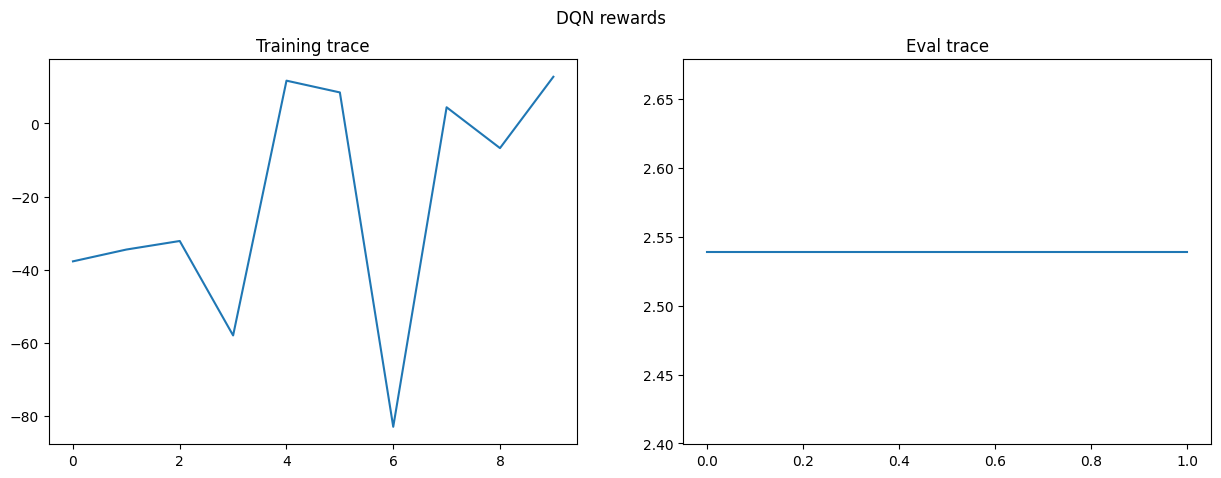

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].plot(tr_trace, label="training rewards")
ax[0].set_title("Training trace")

ax[1].plot(eval_trace_mean, label="eval mean reward")
ax[1].set_title("Eval trace")

fig.suptitle("DQN rewards")

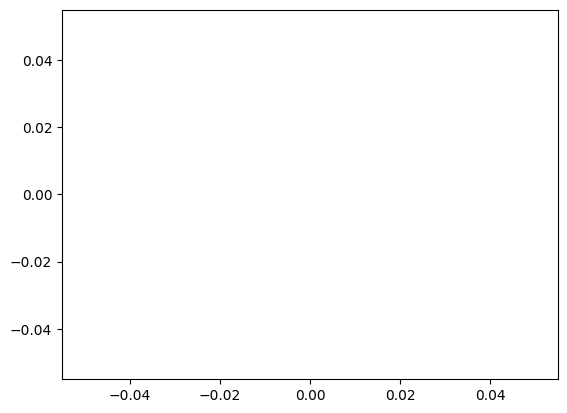

In [32]:
plt.plot(tr_losses)

In [33]:
print("1 means confine, 0 means no action")
eval_rewards = simulate_policy(policy_net, eval_seed_sequences, discount_factor=discount_factor, device=device, logging=True)
print(eval_rewards)

1 means confine, 0 means no action
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  -> reward: 3.540
Parameters(day=210, suceptible=3744950, exposed=0, infected=0, recovered=4925, dead=18, initial_population=3749837)

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  -> reward: 3.533
Parameters(day=210, suceptible=3745325, exposed=0, infected=0, recovered=4721, dead=14, initial_population=3749837)

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  -> reward: 3.532
Parameters(day=210, suceptible=3743149, exposed=0, infected=0, recovered=6934, dead=13, initial_population=3749837)

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  -> reward: 1.986
Parameters(day=210, suceptible=3613204, exposed=0, infected=0, recovered=138175, dead=578, initial_population=3749837)

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  -> reward: 3.559
Parameters(day=210, suceptible=3746813, exposed=0, infected=0, recovered=3018, dead=7, initial_populatio